# FAKE NEWS

The goal of this project is to develop a classification machine learning model that will deduct whether a given news article is true or fake (reliable or unreliable). 

## Table of Contents:
* [Data Preparation](#bullet-1)
  + [Load Data](#bullet-1-1)
  + [Exploratory Data Analysis (EDA)](#bullet-1-2)
    - [Missing Data](#bullet-1-2-1)
    - [Encode Categorical Data](#bullet-1-2-2)
    - [Feature Correlation](#bullet-1-2-3)
    - [Feature Extraction](#bullet-1-2-4)
  + [Split Dataset](#bullet-1-3)
* [Model Development](#bullet-2)
  + [Decision Tree](#bullet-2-1)
  + [K nearest Neighbors](#bullet-2-2)
  + [SVM (Support Vector Classification)](#bullet-2-3)
  + [Naive Bayes](#bullet-2-4)
* [Model Evaluation](#bullet-2)

In [85]:
# Import required libraries
import zipfile, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

## Data Preparation <a class="anchor" id="bullet-1"></a>

### Load Data <a class="anchor" id="bullet-1-1"></a>

Retrieve datasets from Kaggle and save them under the _data_ folder.

In [2]:
# Import dataset as zip
! kaggle competitions download -c fake-news

# Extract datasets from imported zip
with zipfile.ZipFile('./fake-news.zip', 'r') as zip_ref:
  zip_ref.extractall('./data/')

# Delete imported zip
os.remove('./fake-news.zip')

 99%|█████████████████████████████████████▌| 46.0M/46.5M [00:05<00:00, 8.42MB/s]
100%|██████████████████████████████████████| 46.5M/46.5M [00:05<00:00, 8.84MB/s]


We are given 3 datasets: 
+ train.csv: A full training dataset with the following attributes:
  - id: unique id for a news article
  - title: the title of a news article
  - author: author of the news article
  - text: the text of the article; could be incomplete
  - label: a label that marks the article as potentially unreliable
  - 1: unreliable
  - 0: reliable
+ test.csv: A testing training dataset with all the same attributes at train.csv without the label.
+ submit.csv: A sample submission that you can

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_submit = pd.read_csv('./data/submit.csv')

In [4]:
df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
df_test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [6]:
df_submit.head()

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


### Exploratory Data Analysis (EDA) <a class="anchor" id="bullet-1-2"></a>

From the train dataset we can study some data to get the most relevant characteristics of reliable news to extract the features from and feed the model. 

#### Missing Data <a class="anchor" id="bullet-1-2-1"></a>

In [7]:
df_train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

There are several rows with missing data. It makes sense to think that if unreliable articles would be missing either title, author or text. 

In [8]:
print('Reliability of articles missing titles: ', df_train[df_train.title.isnull()].label.unique())
print('Reliability of articles missing authors: ', df_train[df_train.author.isnull()].label.unique())
print('Reliability of articles missing text: ', df_train[df_train.text.isnull()].label.unique())

Reliability of articles missing titles:  [1]
Reliability of articles missing authors:  [1 0]
Reliability of articles missing text:  [1]


All articles missing titles and text are unreliable (1). However, some of the articles missing an author are reliable (0). 

Given the case, instead of dropping the columns with missing values, it's worth keeping a separate feature for missing values. So we can create dummies for missing titles, authors and text.

In [9]:
final_df_train = df_train[['label']].copy()

final_df_train['has_title'] = 1
final_df_train.loc[df_train.title.isnull(), 'has_title'] = 0

final_df_train['has_author'] = 1
final_df_train.loc[df_train.author.isnull(), 'has_author'] = 0

final_df_train['has_text'] = 1
final_df_train.loc[df_train.author.isnull(), 'has_text'] = 0

final_df_train.head()

,label,has_title,has_author,has_text
0,1,1,1,1
1,0,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


#### Encode Categorical Data <a class="anchor" id="bullet-1-2-2"></a>

In [36]:
df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [49]:
# df_train[df_train.author.str.contains('.com')]
df_train['title'][df_train.label == 1]

0        House Dem Aide: We Didn’t Even See Comey’s Let...
2                        Why the Truth Might Get You Fired
3        15 Civilians Killed In Single US Airstrike Hav...
4        Iranian woman jailed for fictional unpublished...
6        Life: Life Of Luxury: Elton John’s 6 Favorite ...
                               ...                        
20788    Maine’s Gov. LePage Threatens To ‘Investigate’...
20791    Lawyer Who Kept Hillary Campaign Chief Out of ...
20793    Idiot Who Destroyed Trump Hollywood Star Gets ...
20798    NATO, Russia To Hold Parallel Exercises In Bal...
20799                            What Keeps the F-35 Alive
Name: title, Length: 10413, dtype: object

#### Feature Correlation <a class="anchor" id="bullet-1-2-3"></a>

We want to understand how dependent are each variable from each other.

In [30]:
corr = final_df_train.corr()
corr

,label,has_title,has_author,has_text
label,1.000000,-0.165824,-0.313305,-0.313305
has_title,-0.165824,1.000000,-0.053507,-0.053507
has_author,-0.313305,-0.053507,1.000000,1.000000
has_text,-0.313305,-0.053507,1.000000,1.000000


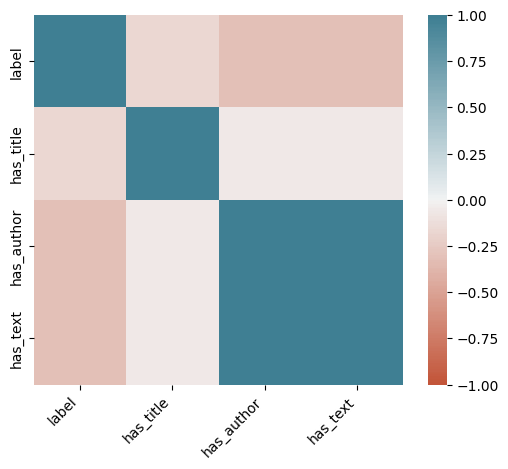

In [34]:
corr = final_df_train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The articles that have an author are extremely correlated with the ones that have a text.

#### Feature Extraction <a class="anchor" id="bullet-1-2-4"></a>

So far, we are only using missing values to fill the final dataset with the relevant features for the model. 

Going back to the original dataset, there might be more data that can be used to fit the model.

In [35]:
df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


#### Split Dataset <a class="anchor" id="bullet-1-2-5"></a>

We want to be able to test the model top evaluate it before testing it with the final test case.

In [24]:
# Select Features
feature = final_df_train.drop('label', axis=1)

# Select Target
target = final_df_train['label']

# Set Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(feature , target, shuffle = True, test_size=0.2, random_state=1)

# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (16640, 3)
Shape of testing feature: (4160, 3)
Shape of training label: (16640,)
Shape of training label: (4160,)


## Modelling <a class="anchor" id="bullet-2"></a>

To analyze the performance of different classification models we can compare their:
- Accuracy: the proportion of true results (true negatives and true positives) among the total number of cases examined
- Precision: the proportion of positives (true positives) among all data that was predicted positive (true positives and false positives) 
- Recall: the proportion of positives (true positives) among all real positives (true positives and false negatives)
- F1 score: a number between 0 and 1 and is the harmonic mean of precision and recall
- Cohen Kappa Score: the agreement between two raters who each classify N items into C mutually exclusive categories
- FPR: Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i]
- TPR: thresholds
- AUC: Area Under the Curve score
- CM: Confusion matrix (indicates the number of samples with true label being i-th class and predicted label being j-th class)

In [91]:
models_evaluation_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Kappa', 'FPR', 'TPR', 'AUC', 'CM'])

def evaluate_model(model, x_test, y_test):

  # Predict Test Data 
  y_pred = model.predict(x_test)

  # Calculate accuracy, precision, recall, f1-score, and kappa score
  acc = metrics.accuracy_score(y_test, y_pred)
  prec = metrics.precision_score(y_test, y_pred)
  rec = metrics.recall_score(y_test, y_pred)
  f1 = metrics.f1_score(y_test, y_pred)
  kappa = metrics.cohen_kappa_score(y_test, y_pred)

  # Calculate area under curve (AUC)
  y_pred_proba = model.predict_proba(x_test)[::,1]
  fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
  auc = metrics.roc_auc_score(y_test, y_pred_proba)

  # Display confussion matrix
  cm = metrics.confusion_matrix(y_test, y_pred)

  return pd.DataFrame([{
          'Model': None,
          'Accuracy': acc, 
          'Precision': prec, 
          'Recall': rec, 
          'F1-Score': f1, 
          'Kappa': kappa, 
          'FPR': fpr, 
          'TPR': tpr, 
          'AUC': auc, 
          'CM': cm
          }])

### Decision Tree <a class="anchor" id="bullet-2-1"></a>

In [92]:
tree = DecisionTreeClassifier()

tree.fit(X_train,y_train)

eval_tree = evaluate_model(tree, X_test, y_test)
eval_tree['Model'] = 'Decision Tree'

models_evaluation_df = pd.concat([models_evaluation_df, eval_tree], axis=0, ignore_index=True)
models_evaluation_df

,Model,Accuracy,Precision,Recall,F1-Score,Kappa,FPR,TPR,AUC,CM
0,Decision Tree,0.613942,0.984962,0.246937,0.394876,0.239316,"[0.0, 0.0, 0.003925417075564278, 1.0]","[0.0, 0.056079170593779454, 0.2469368520263902...",0.621616,"[[2030, 8], [1598, 524]]"


### K nearest Neighbors <a class="anchor" id="bullet-2-2"></a>

In [93]:
k = 4

k_neigh = KNeighborsClassifier(n_neighbors = k)

k_neigh.fit(X_train,y_train)

eval_k_neigh = evaluate_model(k_neigh, X_test, y_test)
eval_k_neigh['Model'] = 'K Nearest Neighbors'

models_evaluation_df = pd.concat([models_evaluation_df, eval_k_neigh], axis=0, ignore_index=True)
models_evaluation_df

,Model,Accuracy,Precision,Recall,F1-Score,Kappa,FPR,TPR,AUC,CM
0,Decision Tree,0.613942,0.984962,0.246937,0.394876,0.239316,"[0.0, 0.0, 0.003925417075564278, 1.0]","[0.0, 0.056079170593779454, 0.2469368520263902...",0.621616,"[[2030, 8], [1598, 524]]"
1,K Nearest Neighbors,0.613942,0.984962,0.246937,0.394876,0.239316,"[0.0, 0.003925417075564278, 1.0]","[0.0, 0.2469368520263902, 1.0]",0.621506,"[[2030, 8], [1598, 524]]"


### SVC (Support Vector Classification) <a class="anchor" id="bullet-2-3"></a> 

In [95]:
svc = SVC(kernel='rbf', probability=True)

svc.fit(X_train,y_train)

eval_svc = evaluate_model(svc, X_test, y_test)
eval_svc['Model'] = 'SVC'

models_evaluation_df = pd.concat([models_evaluation_df, eval_svc], axis=0, ignore_index=True)
models_evaluation_df

,Model,Accuracy,Precision,Recall,F1-Score,Kappa,FPR,TPR,AUC,CM
0,Decision Tree,0.613942,0.984962,0.246937,0.394876,0.239316,"[0.0, 0.0, 0.003925417075564278, 1.0]","[0.0, 0.056079170593779454, 0.2469368520263902...",0.621616,"[[2030, 8], [1598, 524]]"
1,K Nearest Neighbors,0.613942,0.984962,0.246937,0.394876,0.239316,"[0.0, 0.003925417075564278, 1.0]","[0.0, 0.2469368520263902, 1.0]",0.621506,"[[2030, 8], [1598, 524]]"
2,SVC,0.613942,0.984962,0.246937,0.394876,0.239316,"[0.0, 0.0, 0.003925417075564278, 1.0]","[0.0, 0.056079170593779454, 0.2469368520263902...",0.621616,"[[2030, 8], [1598, 524]]"


### Naive Bayes <a class="anchor" id="bullet-2-4"></a> 

In [96]:
gnb = GaussianNB()

gnb.fit(X_train,y_train)

eval_gnb = evaluate_model(gnb, X_test, y_test)
eval_gnb['Model'] = 'Naive Bayes'

models_evaluation_df = pd.concat([models_evaluation_df, eval_gnb], axis=0, ignore_index=True)
models_evaluation_df

,Model,Accuracy,Precision,Recall,F1-Score,Kappa,FPR,TPR,AUC,CM
0,Decision Tree,0.613942,0.984962,0.246937,0.394876,0.239316,"[0.0, 0.0, 0.003925417075564278, 1.0]","[0.0, 0.056079170593779454, 0.2469368520263902...",0.621616,"[[2030, 8], [1598, 524]]"
1,K Nearest Neighbors,0.613942,0.984962,0.246937,0.394876,0.239316,"[0.0, 0.003925417075564278, 1.0]","[0.0, 0.2469368520263902, 1.0]",0.621506,"[[2030, 8], [1598, 524]]"
2,SVC,0.613942,0.984962,0.246937,0.394876,0.239316,"[0.0, 0.0, 0.003925417075564278, 1.0]","[0.0, 0.056079170593779454, 0.2469368520263902...",0.621616,"[[2030, 8], [1598, 524]]"
3,Naive Bayes,0.613942,0.984962,0.246937,0.394876,0.239316,"[0.0, 0.003925417075564278, 1.0]","[0.0, 0.2469368520263902, 1.0]",0.621506,"[[2030, 8], [1598, 524]]"
